# Lecture 4, Part 2 (starts at 1:09:40) and Lecture 5 (first 30 minutes)

In [1]:
!pip install fastai --upgrade
!pip install nbdev
!pip install azure-cognitiveservices-search-imagesearch

     |████████████████████████████████| 358kB 4.4MB/s 
ERROR: fastai 2.0.7 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 2.6MB 25.2MB/s 


In [2]:
from utils import *

## From dogs and cats, to pet breeds

(From Chapter 5: Image Classification)

In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
# When we print out, it shows us relative to the path
Path.BASE_PATH = path

In [6]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [7]:
(path/"images").ls()

(#7393) [Path('images/Bengal_151.jpg'),Path('images/saint_bernard_171.jpg'),Path('images/yorkshire_terrier_125.jpg'),Path('images/Birman_111.jpg'),Path('images/leonberger_45.jpg'),Path('images/Sphynx_185.jpg'),Path('images/Ragdoll_159.jpg'),Path('images/wheaten_terrier_26.jpg'),Path('images/Bombay_14.jpg'),Path('images/Abyssinian_137.jpg')...]

In [8]:
# My own attempt at regex problem
import re
sample_fp = '/root/.fastai/data/oxford-iiit-pet/images/Bengal_151.jpg'
matches = re.search(r"/(\w+)_(\d+)", sample_fp)
print(matches.group(1))
print("---------------")

# Testing regex on first 15 filepaths.
for fp in (path/"images").ls()[:15]:
  matches = re.search(r"/(\w+)_(\d+).jpg", str(fp))
  print(matches.group(1))

Bengal
---------------
Bengal
saint_bernard
yorkshire_terrier
Birman
leonberger
Sphynx
Ragdoll
wheaten_terrier
Bombay
Abyssinian
Russian_Blue
Siamese
english_setter
miniature_pinscher
beagle


In [9]:
fname = (path/"images").ls()[0]

In [10]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Bengal']

In [11]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

Resize followed by aug_transforms is called presizing. First we resize to a larger image which is a square. Second, we do aug transforms on the GPU, where we zoom, rotate, warp, etc. In fastai, we do coordinate transforms not on the pixels. Once at the very end, we do the interpolation. This results in a higher quality image to do training with.

`blocks` is an ordered list, which can be more than 2 blocks.

### Checking and debugging a DataBlock

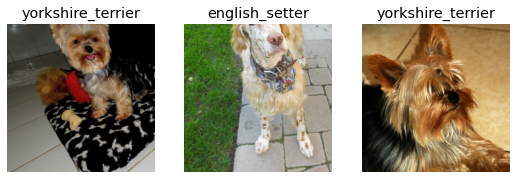

In [12]:
dls.show_batch(nrows=1, ncols=3)

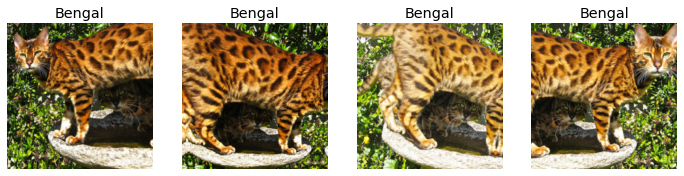

In [13]:
dls.show_batch(nrows=1, ncols=4, unique=True)

In [15]:
# Here is an example of getting summary for a DataBlock object that was
# not well specified (e.g., missing Resize transform)

pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed=42),
                  get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))

pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_23.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x290
  Pipeline: partial -> Categorize -- {'vocab': (#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...], 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_23.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': (#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...], 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=500x290, TensorCategory(1

RuntimeError: ignored

In [16]:
# Train a simple model as soon as possible to get baseline results
# Model can teach you about the data with your model
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.507764,0.352779,0.109608,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.490294,0.309978,0.098782,01:14
1,0.320627,0.250465,0.083897,01:13


It is better to use the trained model to identify mislabeled images and clean the data.

fastai will try to pick a loss function if it is not specified.

In [17]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Cross-Entropy Loss

* Cross-entropy loss is similar to loss function created for MNIST Sample in the previous chapter.
* Cross-entropy loss has two benefits: (1) works even when dependent variable has more than 2 categories; and (2) results in faster, more reliable training.

### Viewing Activations and Labels

In [18]:
x, y = dls.one_batch()

In [19]:
y

TensorCategory([ 3,  6, 12, 21,  6, 10, 29, 19, 22,  6, 21,  1, 11,  9, 16,  0, 35, 35, 17, 26,  3,  0, 27,  0, 15, 25, 10, 31, 28,  1,  1, 27,  5,  1,  9, 28,  5, 12,  6, 13, 26, 35, 34, 16, 14,  8, 13, 32,
        33, 33, 28,  4, 15, 24, 11, 26,  4, 10,  1, 22, 30, 34,  6, 20], device='cuda:0')

In [20]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [21]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([8.9879e-06, 1.4027e-04, 4.2096e-03, 9.8782e-01, 2.1139e-03, 9.8549e-06, 1.1741e-03, 9.4689e-05, 2.3766e-04, 9.0256e-04, 1.1919e-04, 4.6985e-04, 1.3397e-06, 1.2072e-05, 6.9629e-05, 2.2962e-06,
        2.5201e-04, 1.1921e-05, 3.1242e-05, 2.8567e-05, 1.3658e-05, 3.5038e-05, 9.3740e-06, 1.2273e-04, 2.1785e-04, 7.3220e-05, 3.8102e-05, 6.0313e-04, 1.4680e-04, 2.8714e-05, 4.3467e-05, 3.4959e-04,
        4.3561e-04, 1.0288e-05, 7.0168e-05, 2.4117e-05, 6.9993e-05])

In [22]:
print(len(preds[0]))
print(preds[0].sum())

37
tensor(1.0000)


### Softmax

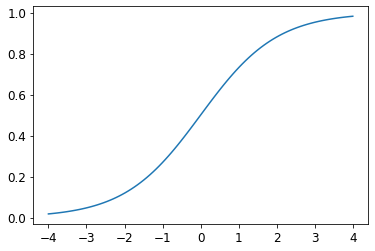

In [23]:
plot_function(torch.sigmoid, min=-4, max=4)

In [24]:
torch.random.manual_seed(42)

In [25]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [26]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [27]:
F.softmax(acts)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [28]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [29]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [30]:
softmax(acts)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [31]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [32]:
targ = tensor([0,1,0,1,1,0])

In [33]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [34]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [35]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [36]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

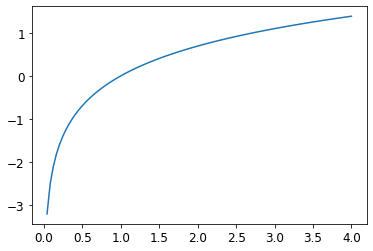

In [37]:
plot_function(torch.log, min=0, max=4)

In [38]:
loss_func = nn.CrossEntropyLoss()

In [39]:
loss_func(acts, targ)

tensor(1.8045)

In [40]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [41]:
# `reduction=None` disables PyTorch from taking mean loss of all items
# instead, it shows loss for all items
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Questions

* Why does loss function need to be negative? It doesn't, but we want something the lower it is, the better. And we need it to cutoff somewhere.

# Lecture 5 starts here

## Model Interpretation

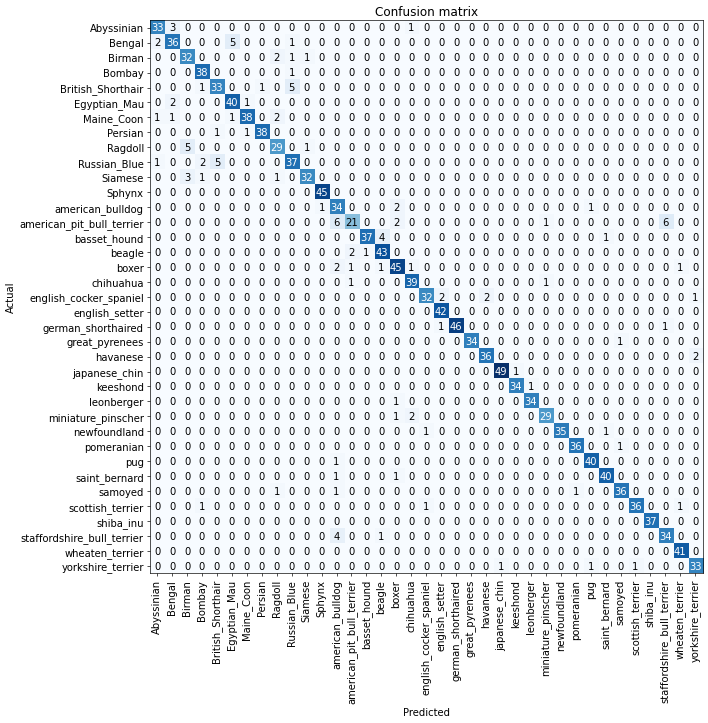

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
# Show cells of the confusion matrix with the most incorrect predictions
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'american_bulldog', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Ragdoll', 'Birman', 5),
 ('Russian_Blue', 'British_Shorthair', 5)]

## Improving Our Model

In [45]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.651524,4.562773,0.460758,01:10


epoch,train_loss,valid_loss,error_rate,time
0,3.236401,1.787511,0.458728,01:14


Why is error_rate higher with a bigger learning rate? We stepped so much that we overshot the minimum loss.

Learning rate finder (Leslie Smith) is a great tool to help us find the optimal learning rate. Do first mini-batch at low learning rate. Then increase learning rate for another mini-batch. And then more.

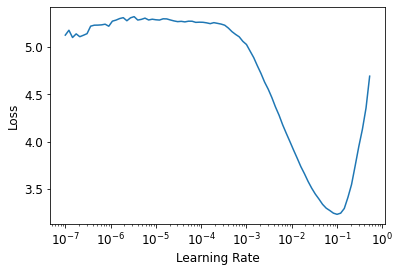

In [46]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [47]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 5.25e-03


In [48]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,0.968536,0.492963,0.133288,01:10


epoch,train_loss,valid_loss,error_rate,time
0,1.037021,1.053339,0.246279,01:14
1,0.534185,0.338923,0.095399,01:14


## Unfreezing and transfer learning

When we call `fine_tune` nmethods, fastai does two things:
* Trains randomly added layers for one epoch, with all other layers frozen
* Unfreezes all the layers, and trains them for the number of epochs requested

In [50]:
learn.fine_tune??
# First we call freeze. Only the last layer's weights are calculated
# by the optimizer.
# Second, we call fit_one_cycle. It fits the randomly added weights.
# Third, we reduce the learning rate by 2.
# Fourth, we unfreeze all layers.
# Fifth, we fit for more epochs

In [51]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3) # 3 epochs training the last layer

epoch,train_loss,valid_loss,error_rate,time
0,1.188818,0.397456,0.117727,01:11
1,0.550784,0.282739,0.087957,01:10
2,0.326423,0.235517,0.077131,01:08


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=8.31763736641733e-06)

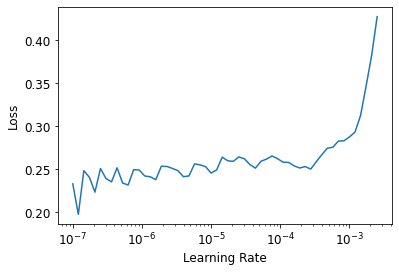

In [52]:
# Unfreeze model and run `lr_find` again
learn.unfreeze()

learn.lr_find()

In [53]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.242590,0.227622,0.073072,01:14
1,0.244816,0.215500,0.065629,01:12
2,0.223052,0.215600,0.066306,01:13
3,0.194752,0.210100,0.065629,01:12
4,0.179773,0.209198,0.066306,01:11
5,0.169383,0.205270,0.063599,01:11


## Discriminative learning rates

In [54]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.108537,0.334761,0.102842,01:06
1,0.494406,0.290381,0.086604,01:06
2,0.317185,0.261612,0.076455,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.255709,0.256768,0.074425,01:11
1,0.233723,0.244700,0.073072,01:11
2,0.220770,0.235493,0.075778,01:11
3,0.214657,0.228764,0.074425,01:11
4,0.195677,0.230140,0.074425,01:11
5,0.168084,0.223157,0.073748,01:12
6,0.156124,0.217740,0.069012,01:11
7,0.144103,0.225446,0.073072,01:11
8,0.142318,0.224021,0.069012,01:11
9,0.130179,0.222266,0.066982,01:11


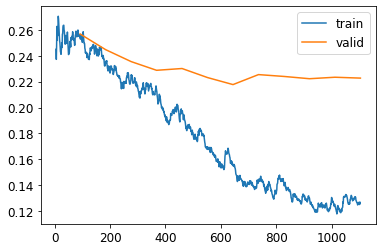

In [55]:
learn.recorder.plot_loss()

## Deeper Architectures

Deeper architectures don't always produce the best results. Test initially with smaller models.

In [56]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.385227,0.339045,0.110284,01:04
1,0.584737,0.312057,0.104195,01:05
2,0.424878,0.307005,0.102842,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.250471,0.245106,0.071042,01:07
1,0.314716,0.348487,0.106225,01:07
2,0.229566,0.343579,0.096752,01:07
3,0.155748,0.252039,0.071719,01:07
4,0.092275,0.209344,0.065629,01:08
5,0.056639,0.193445,0.057510,01:07


Questions:
* How do you know when to do better? Always assume you can do better and just try.

## Questionnaire

Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU? Much quicker to do image transformations on a GPU. And when we do all the image transformations in one step, we have higher quality transforms.

If you are not familiar with regular expressions, find a regular expression tutorial and some problem sets, and complete them. Have a look on the book’s website for suggestions. **[DONE]**

What are the two ways in which data is most commonly provided for most deep learning datasets? Either we have image data in (sub)directories? corresponding to classes (possibly with classes in the filenames) or we have links or filepaths to data and their respective classes in a spreadsheet.

Look up the documentation for L and try using a few of the new methods that it adds. **[DONE]**

Look up the documentation for the Python pathlib module and try using a few methods of the Path class. **[DONE]**

Give two examples of ways that image transformations can degrade the quality of the data. It can have reflection padding artifacts or parts of the original image could disappear.

What method does fastai provide to view the data in a DataLoaders? `dls.show_batch()`

What method does fastai provide to help you debug a DataBlock? `.summary()`

Should you hold off on training a model until you have thoroughly cleaned your data? No. Use the model training to clean the data, as shown before.

What are the two pieces that are combined into cross-entropy loss in PyTorch? Log-Softmax `log_softmax` and Negative log likelihood loss `nll_loss`.

What are the two properties of activations that softmax ensures? Why is this important? Softmax ensures that activations are between 0 and 1 and that they all sum to 1.

When might you want your activations to not have these two properties? It might be less ideal during inference, as it could be better to know when the model is not confident about any one class.

Calculate the exp and softmax columns of Figure 5-3 yourself (i.e., in a spreadsheet, with a calculator, or in a notebook). **[DONE]**

Why can’t we use torch.where to create a loss function for datasets where our label can have more than two categories? `torch.where` works best for 2 categories. Documentation shows that it can return at max 2 different values, `x` and `y`.

What is the value of log(–2)? Why? Domain of logarithmic function is from (0, +inf). Logarithmic function cannot take negative inputs.

What are two good rules of thumb for picking a learning rate from the learning rate finder? You can either pick one order of magnitude less than where the minimum loss was achieved. You can also pick the last point where the loss was clearly decreasing.

What two steps does the fine_tune method do? First it learns parameters for newly added layers to pre-trained model. Then it unfreezes the entire model and learns for a specified number of epochs.

In Jupyter Notebook, how do you get the source code for a method or function? `??` after function/method name.

What are discriminative learning rates? It is about applying smaller learning rates to earlier parts of the network and progressively higher learning rates in the later parts of the network.

How is a Python slice object interpreted when passed as a learning rate to fastai? It means that the minimum value goes to earliest layers with progressive increase to later layers.

Why is early stopping a poor choice when using 1cycle training? Epochs in the middle occur before learning rate has change to reach small values, where it can find the best result.

What is the difference between resnet50 and resnet101? resnet101 has more layers, but the architectural choices are very similar. resnet101 is just a deeper resnet model.

What does to_fp16 do? It enables us to use less precide floating point numbers on the GPU. This can accelerate training time and address GPU (Cuda) memory errors.

## Further Research

Find the paper by Leslie Smith that introduced the learning rate finder, and read it.

See if you can improve the accuracy of the classifier in this chapter. What’s the best accuracy you can achieve? Look on the forums and the book’s website to see what other students have achieved with this dataset and how they did it.

### Figure 5-3

In [61]:
outputs = np.array([0.02, -2.49, 1.25])
print('outputs:', outputs)
print('exp:', np.exp(outputs))
print('softmax', np.exp(outputs)/np.exp(outputs).sum())

outputs: [ 0.02 -2.49  1.25]
exp: [1.02020134 0.08290997 3.49034296]
softmax [0.22209894 0.01804959 0.75985147]


In [62]:
torch.where?

In [64]:
np.log(-2.)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [66]:
doc(L)

In [70]:
t = L(range(12))

In [71]:
t

(#12) [0,1,2,3,4,5,6,7,8,9...]

In [74]:
# Show subdirectories
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[Path('.config'), Path('models'), Path('__pycache__'), Path('sample_data')]